# Случайность в вероятности и на практике

О подходах к понятию случайности: 

Н.К. Верещагин, В.А. Успенский, А. Шень. Колмогоровская сложность и алгоритмическая случайность. 
https://www.mccme.ru/free-books/shen/kolmbook.pdf

А.Н. Ширяев. Случайность в вероятности (доклад на семинаре кафедры теории веротяностей). http://www.mathnet.ru:8080/PresentFiles/21897/bsk_2018_10_17_shiryaev_an_randomness_in_probability_slides.pdf

## Генераторы случайных чисел

Что происходит при вызове, напрмер, ```np.random.rand()```?

Как устроен источник случайной последовательности?

![img](https://cdn.ablebits.com/_img-blog/random-generator/random-generator.png)

Рассмотрим простой и популрный алгоритм - Linear congruential generator (LCG). При вызове функции ```rand()``` в C/C++ происзодит обращение именно к LCG.

Linear congruential generator производит последовательность:
$$ z_{i+1} = (az_i + c) \mod m $$

Число $z_0$ называется *seed* и обеспечивает воспроизводимость последовательности “случайных” чисел.

Напишем функцию, которая реализует LCG:

In [11]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m

# setting the seed
rng.current = 1

Выведем несколько первых элементов последовательности:

In [3]:
[rng() for i in range(10)]

[0.25693503906950355,
 0.5878706516232342,
 0.15432575810700655,
 0.767266943352297,
 0.9738139626570046,
 0.5858681506942958,
 0.8511155843734741,
 0.6132153405342251,
 0.7473867232911289,
 0.06236015981994569]

Выбор параметров $m$, $a$ и $c$ существенно влияет на качество последовательности. Если параметры выбрать наобум, это может привести к неожиданным последствиям:

In [31]:
def rng(m=97, a=5, c=0):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 7

random = [rng() for i in range(1000)]
print("This sequence looks as random:")
random[:10]

This sequence looks as random:


[0.36082474226804123,
 0.8041237113402062,
 0.020618556701030927,
 0.10309278350515463,
 0.5154639175257731,
 0.5773195876288659,
 0.8865979381443299,
 0.4329896907216495,
 0.16494845360824742,
 0.8247422680412371]

Гистограмма распределения похожа на равномерное:

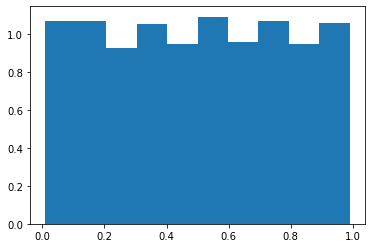

In [32]:
import matplotlib.pyplot as plt
plt.hist(random, density=True)
plt.show()
#по оси y - частота x

Однако, спектральный тест показывает, что точки располагаются на гиперплоскостях, что плохо согласуется с предствалением о случайности:

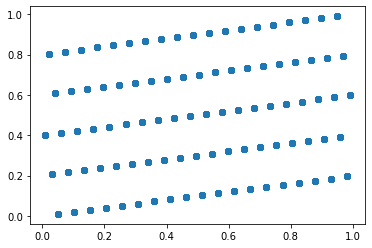

In [18]:
plt.scatter(random[1:], random[:-1])
plt.show()

Более аккуратный выбор параметров приводит с более "случайному" распределению:

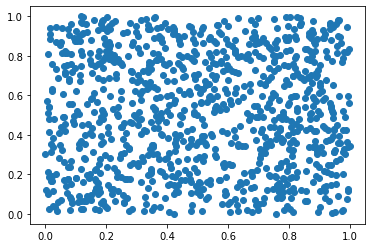

In [341]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 1

random = [rng() for i in range(1000)]
plt.scatter(random[1:], random[:-1])
plt.show()

Существует набор тестов для проверки "случайности". Например, тесты [Diehard tests](https://en.wikipedia.org/wiki/Diehard_tests).

Больше методов генерации собрано [здесь](https://en.wikipedia.org/wiki/List_of_random_number_generators).

Сюжет про динамические системы и переход к хаосу https://www.youtube.com/watch?v=ovJcsL7vyrk&feature=youtu.be

## Генерация выборки из заданного распределения

Допустим, у нас есть генератор случайных числе из отрезка [0, 1]. Как получить выборку из нового распределения $F$?



### Задача
Смоделировать выборку объема 1000 из дискретного распределения на множестве цифр 0, 1, 2, ..., 9 с весами 0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2. По выборке построить гистограмму. Оптимизируйте алгоритм, упорядочив веса. Сравните время генерации выборки с неупорядоченными и упорядоченными весами.


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [92]:
elements =np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
probabilities1 = np.array([0.12, 0.3, 0.167, 0.024, 0.031,0.23, 0.01, 0.02, 0.008, 0.09])
probabilities2= np.sort(probabilities*(-1))
probabilities2 = probabilities2*(-1)

Time1 =  0.0007648468017578125
Time2 =  0.0006310939788818359


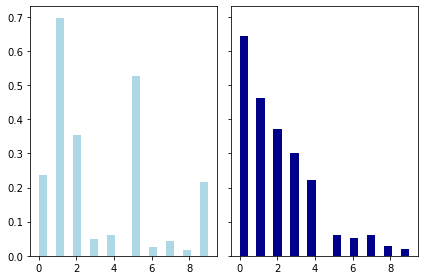

In [130]:
start = time.time()
random1 = np.random.choice(elements, 1000, p=probabilities1)
end = time.time()
print("Time1 = ", end-start)
start = time.time()
random2 = np.random.choice(elements, 1000, p=probabilities2)
end = time.time()
print("Time2 = ", end-start)
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(random1, 20,  density = True, color='lightblue')
axs[1].hist(random2, 20,  density = True, color='darkblue')
plt.show()

Время генерации выборки с упорядоченными весами немного меньше, нежели с неупорядоченными.

### Inverse transform method

В следующем предложении заключается идея метода *inverse transform*:

Если $\xi$ имеет равномерное распределение в $[0,1]$, тогда $F^{-1}(\xi)$ распределена по закону $F$. (Для каких $F$ это верно?)

### Задача
Смоделируйте выборку размера 1000 из распределения $Exp(\lambda)$. Постройте выборочную гистограмму и точный график плотности распределения.

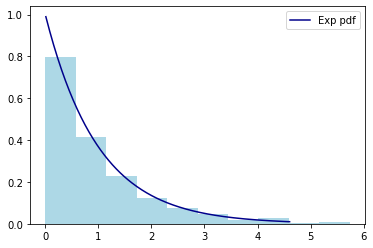

In [107]:
from scipy.stats import expon
random = np.random.exponential(1,1000)
plt.hist(random, density = True, color = 'lightblue')

x = np.linspace(expon.ppf(0.01),expon.ppf(0.99), 250)
plt.plot(x, expon.pdf(x), c = 'darkblue' , label='Exp pdf')
plt.legend()
plt.show()

### Rejection sampling (Accept-reject method)

Идея метода: сэмплить из распределения, из которого умеем, а затем отбирать точки, которые следуют нужному распределению. Картинка иллюстрирует идею метода:
<img src=https://colcarroll.github.io/hamiltonian_monte_carlo_talk/images/bayes_talk.015.png style="width: 50%;"/>
 

### Задача
Обоснуйте, что метод accept-reject действительно производит выборку из нужного распределения. Смоделируйте 1000 точек из усеченного распределения Коши, приведенного ниже, используя генератор равномерного распределения. Нарисуйте график полученной выборочной гистограммы и сравните его с графиком точной функции плотности.

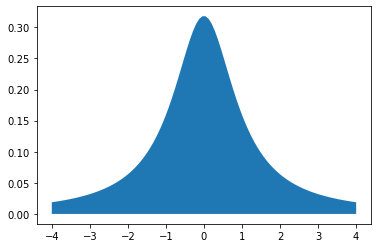

In [114]:
from scipy import stats
import numpy as np
dist = stats.cauchy()
x = np.linspace(-4, 4, 100)
plt.fill_between(x, 0, dist.pdf(x)) #needs to be normalized!
plt.show()

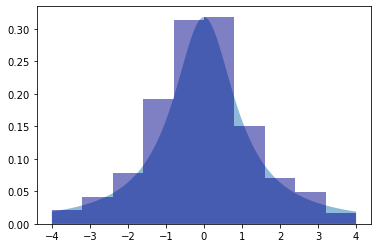

In [124]:
dist = stats.cauchy()
x = np.linspace(-4, 4, 100)
random = np.random.standard_cauchy(1000)
plt.hist(random, range=(-4,4) , density=True, alpha = 0.5, color = "darkblue")
plt.fill_between(x, 0, dist.pdf(x), alpha= 0.5) #needs to be normalized!
plt.show()

##  Coordinate transformation method

Метод аccept-reject в ряде случаев может оказываться неэффективным и требовать слишком много пробных точек. Альтернатива -  попробовать найти преобразование координат, которое переводит простую область (из которой легко сэмплить, например, едининчный квадрат) в требуемую, но при этом сохраняет соотношение площадей.

### Задача
Смоделировать выборку из 500 точек равномерно распределенных внутри данного треугольника без использования метода отбора. 

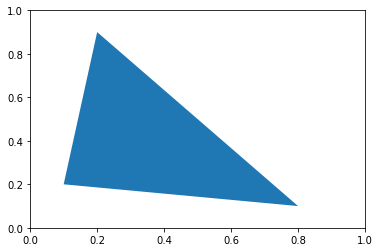

In [131]:
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

polygon = Polygon(0.1 * np.array([[1, 2], [2, 9], [8, 1]]), True)
plt.gca().add_collection(PatchCollection([polygon]))
plt.show()

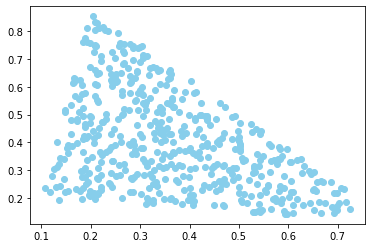

In [141]:
x = np.random.uniform(size=500)
y = np.random.uniform(size=500)

cond = (x + y) > 1
x[cond] = 1 - x[cond]
y[cond] = 1 - y[cond]

x =  0.7 * x + 0.1 * y + 0.1
y = -0.1 * x + 0.7 * y + 0.2

plt.scatter(x, y, color = 'skyblue')
plt.show()

### Задача
Смоделировать выборку из 500 точек внутри данного круга без использования метода отбора.

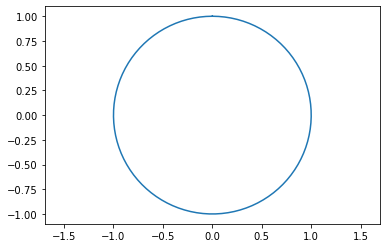

In [142]:
from matplotlib.patches import Circle
t = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.sin(t), np.cos(t))
plt.axis('equal')
plt.show()

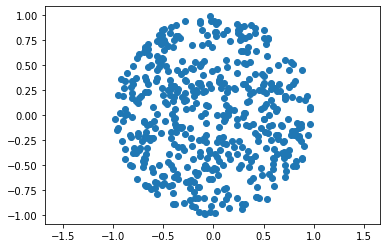

In [148]:
r = np.sqrt(np.random.uniform(0, 1, 500))
phi = np.random.uniform(0, 2*np.pi, 500)

x = r * np.cos(phi)
y = r * np.sin(phi)

plt.scatter(x, y)
plt.axis('equal')
plt.show()

### Задача
Напишите функцию, которая моделирует случайное симметричное блуждание на двумерной решетке длины n c началом и концом в точке (0, 0). Приведите графики выборочных траекторий для n=100.

In [181]:
def f(n):
    a_index = np.random.choice(np.arange(n), n // 2, replace=False)
    b_index = np.random.choice(np.arange(n), n // 2, replace=False)

    a_steps = np.ones(n)
    a_steps[a_index] = -1

    b_steps = np.ones(n)
    b_steps[b_index] = -1

    a = np.cumsum(a_steps)
    b = np.cumsum(b_steps)
    #поворот осей координат на 45 градусов способствует независимости компонент случайного вектора
    x = (a + b) / 2 
    y = (b - a) / 2
    return(x,y)

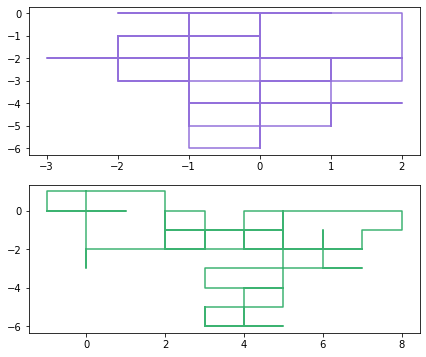

In [197]:
n = 100
x1,y1 = f(n)
x2,y2 = f(n)
fig,ax = plt.subplots(2,1, figsize=(7,6))
ax[0].plot(x1,y1, color = 'mediumpurple')
ax[1].plot(x2,y2, color = 'mediumseagreen')
plt.show()

## Random normal generator

### Задача
Докажите, что приведенный ниже алгоритм (Box-Muller algorithm) формирует выборку из независимых N(0,1) случаных величин. Модифицируйте метод, чтобы исключить вызовы тригонометрических функций ```np.sin``` и ```np.cos```. С помощью модифицированного метода смоделируйте выборку объема 1000 из двумерного гауссовского распределения со средним (3, 6) и ковариационной матрицей ((2, 1), (1, 4)). Постройте 2D гистограмму полученного распределения.

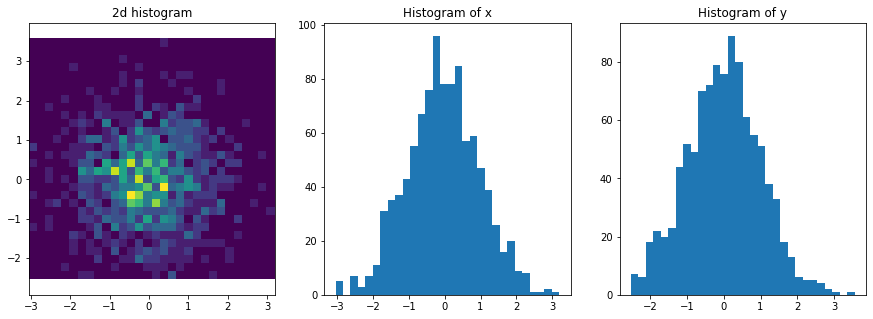

In [251]:
n = 1000
u1, u2 = np.random.rand(2, n)
r = np.sqrt(-2 * np.log(u1))
theta = 2 * np.pi * u2
x = r * np.cos(theta)
y = r * np.sin(theta)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist2d(x, y, bins=30)
ax[0].axis('equal')
ax[1].hist(x, bins=30)
ax[2].hist(y, bins=30)
ax[0].set_title("2d histogram")
ax[1].set_title("Histogram of x")
ax[2].set_title("Histogram of y")
plt.show()

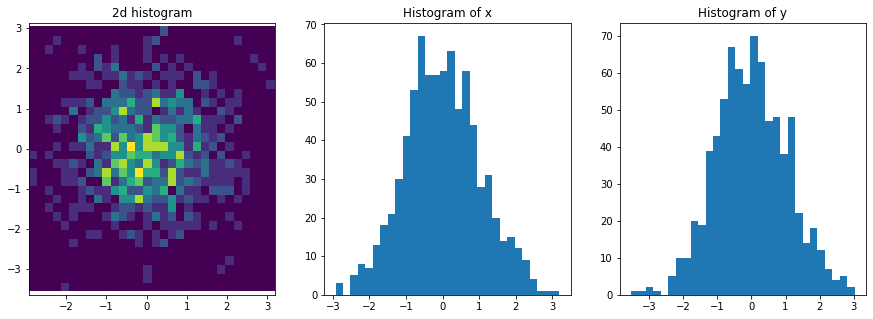

In [318]:
n = 1000
cos = np.array([])
sin = np.array([])
for i in np.arange(n):
    u, v = 2*np.random.rand(2)-1 #генерируем точки из отрезка [-1;1]
    s = u**2+v**2 #условие на тригонометрическое тождество
    if 0<s<=1:
        cos = np.append(cos, u)
        sin = np.append(sin, v)

s = cos**2+sin**2
r = np.sqrt(-2 * np.log(s)/s)
x = r * cos
y = r * sin
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist2d(x, y, bins=30)
ax[0].axis('equal')
ax[1].hist(x, bins=30)
ax[2].hist(y, bins=30)
ax[0].set_title("2d histogram")
ax[1].set_title("Histogram of x")
ax[2].set_title("Histogram of y")
plt.show()

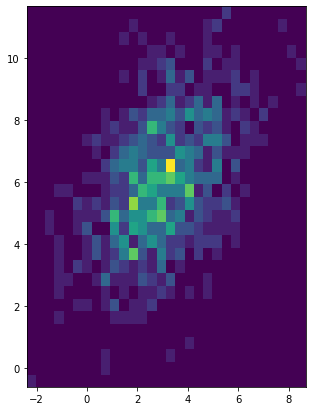

In [319]:
a = np.transpose(np.linalg.cholesky([[2, 1], [1, 4]])) #разложение Холецкого.
x1, y1 = np.matmul(a, [x,y])+ np.reshape(np.array([3,6]),(2,1))
plt.figure(figsize=(5,7))
plt.hist2d(x1, y1, bins=30)
plt.show()

### Задача
Перейдите от вектора из независимых стандартных нормальных величин к гауссовскому вектору с нулевым средним и заданной ниже ковариационно матрицей. Обоснуйте теоретически и численно, что полученный вектор обладает требуемой ковариационной матрицей.


In [7]:
B = np.array([[ 2.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1.],
              [ 0.,  4.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
              [ 0.,  0.,  4.,  0.,  0.,  0., -1.,  0.,  0.],
              [ 0., -1.,  0.,  4.,  0.,  0.,  0.,  0.,  0.],
              [-1.,  0.,  0.,  0.,  2.,  0.,  0.,  0., -1.],
              [ 0.,  0.,  0.,  0.,  0.,  4.,  0., -1.,  0.],
              [ 0.,  0., -1.,  0.,  0.,  0.,  4.,  0.,  0.],
              [ 0.,  0.,  0.,  0.,  0., -1.,  0.,  4.,  0.],
              [-1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  2.]])

Воспользуемся методом Холецкого (A * A^T = B), т.е A будет соответсвующей матрицей перехода.
Можно заметить, что ранг матрицы равен 8, так как 9 строка это минус сумма первой и пятой.
Поэтому мы получим только преобразование 8 случайных величин, а для девятой проделаем аналогичные линейные преобразования. 

In [8]:
import numpy as np
def multinorm(n):
    a = np.zeros(8*n).reshape(8,n)
    for i in range (8):
        a[i] = np.random.normal(0,1,n)
    return a

In [9]:
N = multinorm(1)
C = np.linalg.cholesky(B[np.arange(8)][:,np.arange(8)])
a = np.zeros(8)+1
a = C.dot(N)
b = np.zeros(9)
for i in range (8):
    b[i] = a[i]
b[8] = -(a[0]+a[4])
print(b)

[ 1.69462947  1.40135725  1.62630414  2.59090949 -0.42735119 -1.90762245
  1.98720295  1.78349612 -1.26727828]


### Задача
С помощью метода Монте-Карло (бросанием случайной точки в квадрат) оцените число $\pi$. Теоретически обоснуйте необходимое число бросаний, чтобы оценить число $\pi$ с точностью 3 знака после запятой и достоверностью 99%. С помощью метода Монте-Карло оцените, сколько на практике требуется бросаний, чтобы достичь с требуемой достоверностью нужной точности.

Теоретически: получим доверительный интервал n > (1000*$\pi$/2 * (1-$\pi$/4) * 2.576)^2 = 754 046 

In [30]:
import math
import random
def monte_carlo(n):
    inside = 0
    for i in np.arange(n):
        x = random.uniform(-1,1)
        y = random.uniform(-1,1)
        if math.sqrt((x**2+y**2)) < 1.0:
            inside += 1
# inside / n = pi / 4
    pi = (float(inside) / n) * 4
    return(pi)
monte_carlo(700000)

3.14124

### Задача

Реализовать метод генерации случайного разбиения n-элементного множества на подмножества. С его помощью оценить ожидаемое число подмножеств в случайном разбиении множества из 100 элементов. 

Подсказка 1: Ширяев, Вероятность, т1, задача 2 к параграфу 1.

Подсказка 2: http://djalil.chafai.net/blog/2012/05/03/generating-uniform-random-partitions/

In [388]:
def gen_subset(n):
    p = np.zeros(n)
    f = 1
    for i in range(n):
        f *= (i + 1)
        p[i] = (i + 1)**n / f
    p /= p.sum()
    size=1000
    num_groups = np.random.choice(np.arange(1, n + 1), p=p, size=size)
    a = np.zeros((size, n))
    for i in range(size):
        a[i, :] = np.random.choice(np.arange(1, num_groups[i] + 1), size=n)
    return a

In [389]:
gen_subset(100).max(axis=1).mean()

29.665